# Rebuilding MIDIGen

The hand-built model was successful, both as a learning tool and in terms of generating music.

There were however limitations, such as the tokenisation algorithm precluding the use of byte pair encoding, not to mention the lack of of tempo, velocity, instrument, chord, pitch bend data etc.

Additionally, due to the rapid, explorative development with little to no tests there are likely bugs lurking.

Finally, the algorithms were written for clarity rather than raw speed and efficiency.

For all of these reasons, it is worth reconstructing the same model using 'off the shelf' components that have been well tested and optimised, such as [MIDITok](https://miditok.readthedocs.io/en/latest/tokenizing_music_with_miditok.html#) for tokenisation and [LucidRain](https://github.com/lucidrains/x-transformers)'s Transformer implementations which include XLMemory and KNN lookup.

## MIDITok

In the words of the website:

>MidiTok uses a common workflow for all its tokenizers, which follows:
>
>1. **Music file preprocessing**: time is downsampled to match the tokenizer’s time resolution, tracks of the same programs are merged, notes with pitches outside >the tokenizer’s pitch range are removed, note velocities and tempos are downsampled, finally notes, tempos and time signatures are deduplicated;
>
>2. **Parsing of global events**: tempos and time signature tokens are created;
>
>3. **Parsing of the tracks events**: notes, chords, controls (pedals…) and tokens specific to each tracks are parsed to create their associated tokens;
>
>4. **Creating time tokens**: the tokens representing the time are created in order to bind the previously created global and track tokens.
>
>The resulting tokens are provided by the tokenizer as one or miditok.TokSequence depending on the tokenizer’s IO format (Tokens & TokSequence input / output format)
>
>`tokenizer.vocab` holds all the basic tokens describing the note and time attributes of music. After Training a tokenizer, a new vocabulary is built with newly created tokens from pairs of basic tokens. This vocabulary can be accessed with `tokenizer.vocab_model`.

The library supports multiple tokenizers and training algorithms including BPE. It is also highly configurable.

In [1]:
import os
os.chdir(r'9 - Rebuild')
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


In [ ]:
from miditok import REMI, TokenizerConfig  # here we choose to use REMI

# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    # "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    # "use_chords": True,
    # "use_rests": False,
    # "use_tempos": True,
    # "use_time_signatures": False,
    # "use_programs": False,
    # "num_tempos": 32,  # number of tempo bins
    # "tempo_range": (40, 250),  # (min, max)
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# https://miditok.readthedocs.io/en/latest/tokenizations.html#remi
tokenizer = REMI(config)

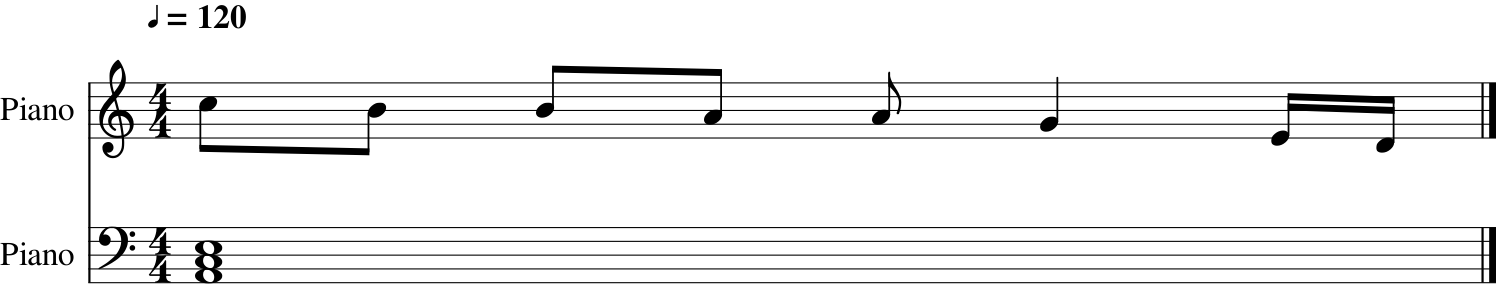

In [4]:
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

single_bar_path = Path('../data/midi/single_bar_example.mid')
single_bar_midi_file = m21.midi.MidiFile()
single_bar_midi_file.open(single_bar_path)
single_bar_midi_file.read()
single_bar_midi_file.close()

single_bar_stream = m21.midi.translate.midiFileToStream(single_bar_midi_file)
single_bar_stream.show()

In [5]:
single_bar_stream.show('midi')

In [6]:
tokens = tokenizer.encode(single_bar_path)  # automatically detects Score objects, paths, tokens
tokens

[TokSequence(tokens=['Bar_None', 'Position_0', 'Pitch_72', 'Velocity_91', 'Duration_0.4.8', 'Position_4', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_8', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_12', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_16', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_20', 'Pitch_67', 'Velocity_91', 'Duration_1.0.8', 'Position_28', 'Pitch_64', 'Velocity_91', 'Duration_0.2.8', 'Position_30', 'Pitch_62', 'Velocity_91', 'Duration_0.2.8'], ids=[4, 189, 56, 115, 128, 193, 55, 115, 128, 197, 55, 115, 128, 201, 53, 115, 128, 205, 53, 115, 128, 209, 51, 115, 132, 217, 48, 115, 126, 219, 46, 115, 126], bytes='', events=[Event(type=Bar, value=None, time=0, desc=0), Event(type=Position, value=0, time=0, desc=0), Event(type=Pitch, value=72, time=0, desc=4), Event(type=Velocity, value=91, time=0, desc=91), Event(type=Duration, value=0.4.8, time=0, desc=4 ticks), Event(type=Position, value=4, time=4, desc=4), Event(type=Pitch, va

Base vocab tokens for sequence:

In [7]:
tokens[0].__len__()

33

In [8]:
tokens[0].tokens

['Bar_None',
 'Position_0',
 'Pitch_72',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_4',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_8',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_12',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_16',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_20',
 'Pitch_67',
 'Velocity_91',
 'Duration_1.0.8',
 'Position_28',
 'Pitch_64',
 'Velocity_91',
 'Duration_0.2.8',
 'Position_30',
 'Pitch_62',
 'Velocity_91',
 'Duration_0.2.8']

In [9]:
syMusicScore = tokenizer.decode(tokens)

single_bar_path_miditok = Path('../data/midi/single_bar_example_miditok.mid')
syMusicScore.dump_midi(single_bar_path_miditok)

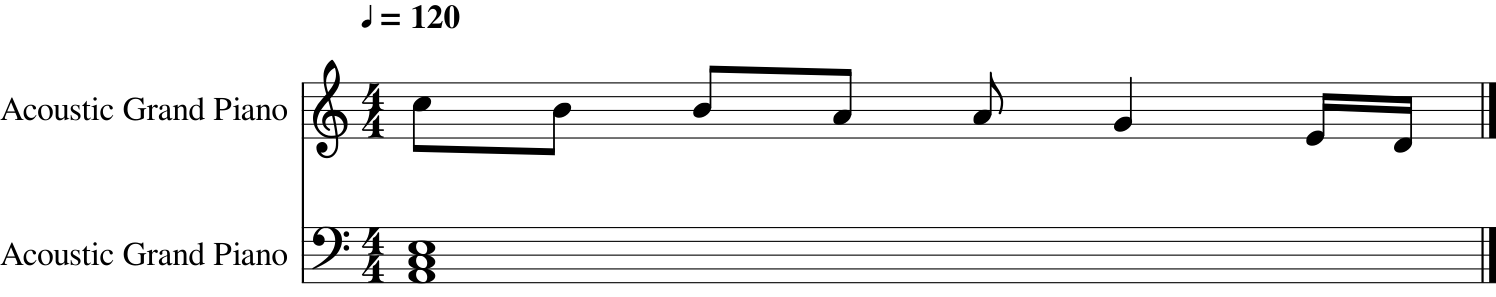

In [10]:
single_bar_miditok_file = m21.midi.MidiFile()
single_bar_miditok_file.open(single_bar_path_miditok)
single_bar_miditok_file.read()
single_bar_miditok_file.close()

single_bar_miditok_stream = m21.midi.translate.midiFileToStream(single_bar_miditok_file)
single_bar_miditok_stream.show()

In [11]:
single_bar_miditok_stream.show('midi')

## Byte Pair encoding

In [12]:
vg_path = Path('../data/midi/vg_large')
vg_tokenizer = REMI()  # using defaults parameters (constants.py)
vg_midi_paths = list(vg_path.glob("**/*.mid"))
vg_tokenizer.train(vocab_size=1000, files_paths=vg_midi_paths)

In [13]:
vg_singlebar_tokseq = vg_tokenizer.encode(single_bar_path)  # automatically detects Score objects, paths, tokens
vg_singlebar_tokseq

[TokSequence(tokens=['Bar_None', 'Position_0', 'Pitch_72', 'Velocity_91', 'Duration_0.4.8', 'Position_4', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_8', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_12', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_16', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_20', 'Pitch_67', 'Velocity_91', 'Duration_1.0.8', 'Position_28', 'Pitch_64', 'Velocity_91', 'Duration_0.2.8', 'Position_30', 'Pitch_62', 'Velocity_91', 'Duration_0.2.8'], ids=[500, 270, 193, 55, 270, 856, 377, 53, 270, 660, 384, 51, 291, 217, 48, 280, 219, 46, 280], bytes='%ÞY\x94¡âX\x94¡æX\x94¡êV\x94¡îV\x94¡òT\x94¥úQ\x94\x9füO\x94\x9f', events=[Event(type=Bar, value=None, time=0, desc=0), Event(type=Position, value=0, time=0, desc=0), Event(type=Pitch, value=72, time=0, desc=4), Event(type=Velocity, value=91, time=0, desc=91), Event(type=Duration, value=0.4.8, time=0, desc=4 ticks), Event(type=Position, value=4, time=4, desc=4), Event(type=Pitch, valu

Trained vocab tokens for sequence:

In [14]:
vg_singlebar_tokseq[0].__len__()

19

In [15]:
vg_singlebar_tokseq[0].tokens

['Bar_None',
 'Position_0',
 'Pitch_72',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_4',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_8',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_12',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_16',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_20',
 'Pitch_67',
 'Velocity_91',
 'Duration_1.0.8',
 'Position_28',
 'Pitch_64',
 'Velocity_91',
 'Duration_0.2.8',
 'Position_30',
 'Pitch_62',
 'Velocity_91',
 'Duration_0.2.8']

We can collapse all parts into one by passing `use_programs = true` which will include program change tokens in the stream.

In [16]:
# Our parameters
PROGRAM_TOKENIZER_PARAMS = {
    "use_programs": True,
    # "program_changes" : True #This will only add Program tokens when the instrument changes rather than at every note

}
program_config = TokenizerConfig(**PROGRAM_TOKENIZER_PARAMS)

# https://miditok.readthedocs.io/en/latest/tokenizations.html#remi
vg_program_tokenizer = REMI(program_config)
vg_program_tokenizer.train(vocab_size=1000, files_paths=vg_midi_paths)

program_singlebar_tokseq = vg_program_tokenizer.encode(single_bar_path)  # automatically detects Score objects, paths, tokens
program_singlebar_tokseq

/opt/conda/lib/python3.11/site-packages/miditok/tokenizations/remi.py:77: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


TokSequence(tokens=['Bar_None', 'Position_0', 'Program_0', 'Pitch_72', 'Velocity_91', 'Duration_0.4.8', 'Program_0', 'Pitch_45', 'Velocity_91', 'Duration_4.0.4', 'Program_0', 'Pitch_48', 'Velocity_91', 'Duration_4.0.4', 'Program_0', 'Pitch_52', 'Velocity_91', 'Duration_4.0.4', 'Position_4', 'Program_0', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_8', 'Program_0', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_12', 'Program_0', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_16', 'Program_0', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_20', 'Program_0', 'Pitch_67', 'Velocity_91', 'Duration_1.0.8', 'Position_28', 'Program_0', 'Pitch_64', 'Velocity_91', 'Duration_0.2.8', 'Position_30', 'Program_0', 'Pitch_62', 'Velocity_91', 'Duration_0.2.8'], ids=[287, 56, 402, 29, 115, 383, 32, 115, 383, 36, 115, 948, 55, 311, 290, 55, 591, 53, 311, 291, 53, 708, 51, 368, 293, 48, 333, 358, 46, 333], bytes='%ÞĻY\x94¡Ļ>\x94½ĻA\x94½ĻE\x94½âĻX\x94¡æĻX\x94¡êĻV\x94¡îĻV\x9

In [17]:
program_singlebar_tokseq.__len__()

30

In [18]:
program_singlebar_tokseq.tokens

['Bar_None',
 'Position_0',
 'Program_0',
 'Pitch_72',
 'Velocity_91',
 'Duration_0.4.8',
 'Program_0',
 'Pitch_45',
 'Velocity_91',
 'Duration_4.0.4',
 'Program_0',
 'Pitch_48',
 'Velocity_91',
 'Duration_4.0.4',
 'Program_0',
 'Pitch_52',
 'Velocity_91',
 'Duration_4.0.4',
 'Position_4',
 'Program_0',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_8',
 'Program_0',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_12',
 'Program_0',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_16',
 'Program_0',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_20',
 'Program_0',
 'Pitch_67',
 'Velocity_91',
 'Duration_1.0.8',
 'Position_28',
 'Program_0',
 'Pitch_64',
 'Velocity_91',
 'Duration_0.2.8',
 'Position_30',
 'Program_0',
 'Pitch_62',
 'Velocity_91',
 'Duration_0.2.8']

Special tokens [aren't added by the tokenizer](https://github.com/Natooz/MidiTok/issues/140). MIDITok does this with its [dataset / collator classes](https://miditok.readthedocs.io/en/latest/pytorch_data.html).

In [19]:
vg_program_tokenizer.special_tokens

['PAD_None', 'BOS_None', 'EOS_None', 'MASK_None']

In [20]:
vg_program_tokenizer.special_tokens_ids

[0, 1, 2, 3]

In [21]:
from miditok.pytorch_data import DatasetMIDI, DataCollator
from torch.utils.data import DataLoader
from miditok import TokSequence

dataset = DatasetMIDI(
    files_paths=vg_midi_paths,
    tokenizer=vg_program_tokenizer,
    max_seq_len=10001, # Very large, most songs are shorter, around 2-5000 tokens
    bos_token_id=vg_program_tokenizer["BOS_None"],
    eos_token_id=vg_program_tokenizer["EOS_None"],
)
collator = DataCollator(vg_program_tokenizer.pad_token_id)

data_loader = DataLoader(dataset=dataset, collate_fn=collator, batch_size=1)

for i, batch in enumerate (data_loader):
    if i < 20:
        print(i, batch["input_ids"].shape)
    else:
        break

0 torch.Size([1, 1595])
1 torch.Size([1, 3942])
2 torch.Size([1, 5997])
3 torch.Size([1, 2255])
4 torch.Size([1, 800])
5 torch.Size([1, 1290])
6 torch.Size([1, 2182])
7 torch.Size([1, 2050])
8 torch.Size([1, 2724])
9 torch.Size([1, 4076])
10 torch.Size([1, 7223])
11 torch.Size([1, 2522])
12 torch.Size([1, 1534])
13 torch.Size([1, 1738])
14 torch.Size([1, 1140])
15 torch.Size([1, 1160])
16 torch.Size([1, 1923])
17 torch.Size([1, 877])
18 torch.Size([1, 1939])
19 torch.Size([1, 1377])


If we make batch size 2, then song 0 and 1 will be in a single batch. Because song 0 has length 1595 and song 2 3942, song 0 will have 2347 padding tokens (`0`) added to the end:

In [22]:
data_loader = DataLoader(dataset=dataset, collate_fn=collator, batch_size=2)

for i, batch in enumerate (data_loader):
    if i == 0:
        print(i, batch["input_ids"].shape)
        print(i, batch["input_ids"][0][1590:1600])
        print(i, batch["input_ids"][1][1590:1600])
    else:
        break

0 torch.Size([2, 3942])
0 tensor([ 63, 451,  67, 858,   2,   0,   0,   0,   0,   0])
0 tensor([319, 292,  32, 349,  36, 502,  49, 492,  24, 327])


In [23]:
for i, batch in enumerate (data_loader):
    if i == 0:
        ids=batch["input_ids"][0] # pytorch tensor
        # convert tensor to list
        ids = ids.cpu().numpy().tolist()
        tokSeq = TokSequence(ids=ids, are_ids_encoded = True)
        vg_program_tokenizer.decode_token_ids(tokSeq) # Only needed if tokenizer trained, so that minted tokens are converted to base vocab
        vg_program_tokenizer.complete_sequence(tokSeq)
        print(tokSeq)
    else:
        break

TokSequence(tokens=['BOS_None', 'Bar_None', 'Position_0', 'Program_1', 'Pitch_31', 'Velocity_87', 'Duration_0.6.8', 'Position_8', 'Program_1', 'Pitch_31', 'Velocity_83', 'Duration_0.6.8', 'Position_16', 'Program_1', 'Pitch_31', 'Velocity_87', 'Duration_0.6.8', 'Position_20', 'Program_1', 'Pitch_59', 'Velocity_87', 'Duration_0.2.8', 'Program_1', 'Pitch_65', 'Velocity_87', 'Duration_0.2.8', 'Program_1', 'Pitch_69', 'Velocity_95', 'Duration_0.2.8', 'Position_24', 'Program_1', 'Pitch_31', 'Velocity_83', 'Duration_0.6.8', 'Program_1', 'Pitch_59', 'Velocity_87', 'Duration_0.2.8', 'Program_1', 'Pitch_65', 'Velocity_87', 'Duration_0.2.8', 'Program_1', 'Pitch_69', 'Velocity_99', 'Duration_0.2.8', 'Position_28', 'Program_1', 'Pitch_59', 'Velocity_87', 'Duration_0.2.8', 'Program_1', 'Pitch_65', 'Velocity_87', 'Duration_0.2.8', 'Program_1', 'Pitch_69', 'Velocity_95', 'Duration_0.2.8', 'Bar_None', 'Position_0', 'Program_1', 'Pitch_36', 'Velocity_95', 'Duration_0.4.8', 'Program_1', 'Pitch_67', 'Velo

There are 3839 files in the vg_large dataset, so we will get 3839 batches with `batch_size=1`, or half of that with `batch_size=2`.

With `max_seq_length=1001` we are only going to get the first 1000 tokens of each song, which is a waste.

To avoid this, we can split the files into ~1000 token songs in order to minimise data thrown away using the MIDITok utilities.

# Contiguous batching for Memorising Transformers

We want contiguous batches for XL and KNN memory, so that memories for a given batch dim make sense.

Last time we implemented a looping ragged (nested) tensor. This is the 'best' solution in terms of functionality but is technically complex and probably had bugs.

To achieve a similar result much more simply, we can lean on the fact that the MIDITok dataloader will only use one file per batch dimension.

We saw this above - e.g. 100 files with a batch size of 2 will result in 50 batches, regardless of song length.

If we set as large-as-possible `max_seq_len`, we will get a file per batch dim and contiguous data in each batch. We can then simply split this long batch into mini batches and loop over them, clearing memory once we are done.

This approach essentially simulates having songs that are the same length, and that length is an integer multiple of our context size, `T`, allowing us to easily split them into chunks. 

          |              Batch 1             |------|            Batch 2               |
|        | MiniBatch 1 | MiniBatch 2 | MiniBatch 3 |        | MiniBatch 4 | MiniBatch 5 | MiniBatch 6 |
|--------|---------|---------|---------|--------|---------|---------|---------|
| Song 1 | Block 1 | Block 2 | Block 3 | Song 5 | Block 1 | Block 2 | Block 3 |
| Song 2 | Block 1 | Block 2 | Block 3 | Song 6 | Block 1 | Block 2 | Block 3 |
| Song 3 | Block 1 | Block 2 | Block 3 | Song 7 | Block 1 | Block 2 | Block 3 |
| Song 4 | Block 1 | Block 2 | Block 3 | Song 8 | Block 1 | Block 2 | Block 3 |

So, we have two conflicting considerations when choosing batch size for the MIDITok dataloader.

- On the one hand, we want it as long as possible as this correlates to how long our memories last before being wiped.

    For example, if we have a minibatch length of 256 and a batch length of 2560, we get 10 iterations of contiguous batches before we have to clear the memory.

- On the other hand, if we have a long batch length then short songs will end up with a lot of padding, for example if we have a batch length of 5000 and batch size 2 with songs of 4500 and 5200, the first will have 500 padding tokens added and the second 200 tokens cropped.

Note - it doesn't seem to pad the longest song if it is shorter than the batch length, so if we have a batch length of 5000 and batch size 2 with songs of 4500 and 4800, then the first dim will be padded only 300 tokens and the second left as it is. If this wasn't the case all batches would be 10k in the above data loader. 

We can get around this to a degree with the file splitting utility, making the minimum and maximum chunk length equal to our batch length, throwing away songs that don't meet the min length and cropping those that exceed an integer multiple of it. 

The splitter isn't exact though as it is based on average tokens-per-note of the chosen encoder, so we could still get a file that is too small and ends up padded, or a batch that isn't as long as `max_seq_length`. That might be OK though - say we have a minibatch length of 200, a max of 1000, and we end up with the longest song in a batch being 800. We can still split it into 4 minibatches. If it was 900, we would have to throw away 100 tokens or pad the last 100.

[torch.chunk](https://pytorch.org/docs/main/generated/torch.chunk.html) will do this kind of best-efforts splitting, wheras [torch.tensor_split](https://pytorch.org/docs/main/generated/torch.tensor_split.html#torch.tensor_split) will clip to the exact split length. See lucidrain's [Memorizing Transformers](https://github.com/lucidrains/memorizing-transformers-pytorch/blob/272e39bafd2a507d21ac896bd7cf4b593ee9acb7/train.py#L96) training example.

Let's try splitting vg_large.

In [24]:
len(vg_midi_paths)

3839

Trying to split the relative path gave
```
ValueError: '../data/midi/vg_large/Professor Layton_Nintendo DS_Professor Layton and the Unwound Future_A Quiet Town.mid' is not in the subpath of '/src/data/midi/vg_large' OR one path is relative and the other is absolute.
```
so resolving absolute path.

In [25]:
absolute_vg_paths = [path.resolve() for path in vg_midi_paths]
absolute_vg_paths[0]

PosixPath('/src/data/midi/vg_large/Ace Attorney_Nintendo 3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People.mid')

In [26]:
from random import shuffle
from miditok.utils import split_files_for_training

chunks_dir = Path('../data/midi/vg_large_miditok_split')
max_vg_large_chunk_length = 1024

# NOTE: Shuffling messes up hash check and causes re-encoding

split_files_for_training(
    files_paths=absolute_vg_paths,
    tokenizer=vg_program_tokenizer,
    save_dir=chunks_dir,
    max_seq_len=max_vg_large_chunk_length,

    # Not recommended by docs but want to see if we can link chunks and retain memories, 
    # clearing on BOS / EOS instead of at the end of a chunk.
    num_overlap_bars=0,
)

Splitting music files (../data/midi/vg_large_miditok_split): 100%|██████████| 3839/3839 [02:22<00:00, 26.93it/s]


[PosixPath('../data/midi/vg_large_miditok_split/Ace Attorney_Nintendo 3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People_0.mid'),
 PosixPath('../data/midi/vg_large_miditok_split/Ace Attorney_Nintendo 3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People_1.mid'),
 PosixPath('../data/midi/vg_large_miditok_split/Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Burglar_0.mid'),
 PosixPath('../data/midi/vg_large_miditok_split/Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Burglar_1.mid'),
 PosixPath('../data/midi/vg_large_miditok_split/Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Burglar_2.mid'),
 PosixPath('../data/midi/vg_large_miditok_split/Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Burglar_3.mid'),
 PosixPath('../data/midi/vg_large_miditok_split/Ace Attorney_N

In [27]:
# from miditok.utils import augment_dataset

# augment_dataset(
#     chunks_dir,
#     pitch_offsets=[-12, 12],
#     velocity_offsets=[-4, 4],
#     duration_offsets=[-0.5, 0.5],
# )

With a batch size of one, will the second batch file be part two of the first?

With batch size 2, will we get A1 B1 then A2 B2?

If so, we already get contiguous batching out of the box.

Note - if this is just a side effect of file ordering it could be flaky unless we explicitly order.

In [ ]:
vg_chunks_paths = list(chunks_dir.glob("**/*.mid"))

dataset = DatasetMIDI(
    files_paths=vg_chunks_paths,
    tokenizer=vg_program_tokenizer,
    max_seq_len=max_vg_large_chunk_length, # Very large, most songs are shorter, around 2-5000 tokens
    bos_token_id=vg_program_tokenizer["BOS_None"],
    eos_token_id=vg_program_tokenizer["EOS_None"],

    #a function to retrieve the label of a file. The method must take two positional arguments: the first is either the miditok.TokSequence returned when tokenizing a file, the second is the path to the file just loaded.
    func_to_get_labels = 
        lambda z, x, y: 
            # Hack to see what files are in each batch
            print(y.stem) or 0

)

collator = DataCollator(vg_program_tokenizer.pad_token_id)

In [29]:
data_loader_b1 = DataLoader(dataset=dataset, collate_fn=collator, batch_size=1)

for i, batch in enumerate (data_loader_b1):
    if i < 20:
        print(batch)
    else:
        break

Ace Attorney_Nintendo 3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People_0
{'input_ids': tensor([[  1, 947, 466, 275,  15, 643, 274,  15, 466, 284,  43, 315,  49, 315,
         996, 276,  15, 677,  43, 315,  49, 315,  53, 416, 283,  43, 315,  49,
         315, 996, 440, 347,  51, 320, 611, 317,  51, 561,  51, 452,  20, 355,
          56, 333, 748, 317,  51, 437,  19, 355,  58, 812, 284,  31, 446,  19,
         355,  58, 812, 283,  31, 288, 834, 737,  29, 317,  56, 452,  17, 355,
          60, 333, 281,  29, 317,  56, 437,  15, 355,  61, 809,  27, 317,  63,
         446,  15, 355,  60, 605,  27, 317,  61, 318, 834, 347,  48, 320, 929,
         317,  48, 561,  48, 452,  17, 355,  53, 333, 281,  29, 317,  48, 437,
          15, 355,  55, 812, 924, 446,  15, 355,  55, 812, 870, 288, 271,  13,
         737,  25, 317,  53, 452,  13, 355,  56, 333, 281,  25, 317,  53, 437,
          12, 355,  58, 809,  24, 317,  60, 446,  12, 317,  56, 605,  24, 317,
          55, 318, 440, 347

In [30]:
data_loader_b2 = DataLoader(dataset=dataset, collate_fn=collator, batch_size=2)

for i, batch in enumerate (data_loader_b2):
    if i < 20:
        print(batch)
    else:
        break

Ace Attorney_Nintendo 3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People_0
Ace Attorney_Nintendo 3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People_1
{'input_ids': tensor([[  1, 947, 466,  ..., 812, 870, 288],
        [271,  13, 737,  ...,   0,   0,   0]]), 'labels': tensor([[0],
        [0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Burglar_0
Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Burglar_1
{'input_ids': tensor([[  1, 287,  12,  ..., 419,  44, 278],
        [648, 337,  46,  ...,   0,   0,   0]]), 'labels': tensor([[0],
        [0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Bur

It is just loading files in order, so with a batch of two with two-chunk songs rather than A1 B1 / A2 B2 we get A1 A2 / B1 B2.

This means that one song may have multiple chunks in a single batch, and by extension we can't expect sequential chunks to correlate.

Using an overlap of 1 will allow the model to have all continuation examples, e.g. with

1 / 2 / 3

4 / 5 / 6

we wouldn't have any example of what comes after 3, wheras with

1 / 2 / 3

3 / 4 / 5

we know 4 comes after 3.

### Shuffling

Shuffling before splitting causes the hash check to be different and so the files will get re-split even though they already exist.

We really don't want multiple chunks of a single file in the same batch, simply because that will bias the gradient of that batch.

This means we should 

- Shuffle before splitting into test / train / validation sets, so songs aren't biased to a set.
- Split the files into chunks for each set.
- Shuffle the chunks when loading, so that parts of a single song aren't biased to a batch.